## Pytorch Custom Datasets

In [273]:
# Main import statements
import torch
import torchvision
from torch import nn
import random
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import os
import pathlib
from typing import List, Tuple, Dict

torch.__version__

'2.3.0+cu118'

In [274]:
# Device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

## 1. Get Data

Getting a dataset that is a subset from Food101 dataset.

Food101 dataset is a large dataset with 101 classes of food. We will use a subset of this dataset with 3 classes and 10% of the original dataset.

75 images per class will be used for training and 25 images per class will be used for validation.

It`s important to note that the dataset is already split into training and validation sets.

Also, when working with ML projects, it is important to start with a small dataset to test the code and the model. After that, we can increase the dataset size.

The whole point is to make sure that the code is working properly before running it on a large dataset.

In [275]:
import requests
import zipfile
from pathlib import Path

# Setup the path for datafolder
DATA_PATH = Path("data")
image_path = DATA_PATH / "pizza_steak_sushi"

# If the image folder does not exist, download the data
if image_path.is_dir():
    print("Data already downloaded.")
else:
    print("Downloading data...")
    # Make the directory
    image_path.mkdir(parents=True, exist_ok=True)

    # Download the data
    with open(DATA_PATH / "pizza_steak_sushi.zip", "wb") as f:
        url = "https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip"
        response = requests.get(url= url)
        f.write(response.content)

    # Unzip the data
    with zipfile.ZipFile(DATA_PATH / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping...")
        zip_ref.extractall(image_path)

Data already downloaded.


## 2. Data preparation and exploration

In [276]:
import os
def walk_through_dir(dir_path):
    """
    Walks through dir_path returning its directories and files
    dir_path: (str) valid path to target directory
    
    """
    for dirpath, dirnames, filenames in os.walk(dir_path):
        """
        dirpath: (str) path to current directory
        dirnames: (list) list of directories in current directory
        filenames: (list) list of files in current directory
        """
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [277]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.


In [278]:
# Setup train and testing directories
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 2.1 Visualizing an image

1. Get all of image paths
2. Pick a random image path using `random.choice` function
3. Get the image class name using `pathlib.Path.parent.stem`
4. Load the image using `PIL.Image.open` function

Image path: data/pizza_steak_sushi/train/sushi/773725.jpg
Image class: sushi
Image size: (382, 512)


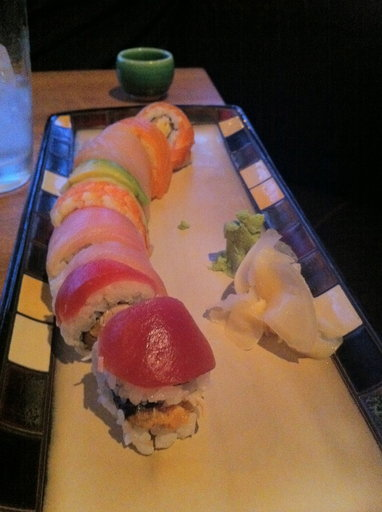

In [279]:
#1. Get all image paths
image_paths = list(image_path.glob("*/*/*.jpg")) 
# Get all images in the image_path directory (pizza_steak_sushi(image_path)/(train or test)/(pizza, steak or sushi/*.jpg)

#2. Picking a random image path
random_image_path = random.choice(image_paths)

#3. Get the image
random_image = Image.open(random_image_path)

#4. Get the class name (steak, pizza, sushi)
class_name = random_image_path.parent.name

#5. Plot the image and image metadata
print(f"Image path: {random_image_path}")
print(f"Image class: {class_name}")
print(f"Image size: {random_image.size}")
random_image

Text(0.5, 1.0, 'Image class: sushi | Image size: (512, 382, 3) -> (H, W, C)')

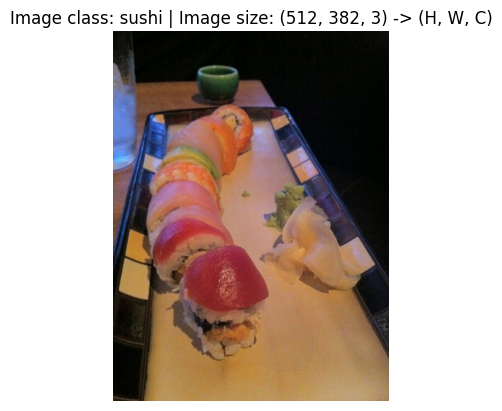

In [280]:
# Turn the image to an array
img_as_array = np.asarray(random_image)

# Plot the image with matplotlib
plt.imshow(img_as_array)
plt.axis(False)
plt.title(f"Image class: {class_name} | Image size: {img_as_array.shape} -> (H, W, C)")

## 3. Transforming data

Before feeding the data into the model, we need to apply some transformations to the data.
1. Turn the image into a tensor
2. Turn it into a `torch.utils.data.Dataset` object and subsequently into a `torch.utils.data.DataLoader` object

### 3.1 Transforming the data with `torchvision.transforms`

`torchvision.transforms` module provides a set of common image transformations. 

In [281]:
# Write a transform for image
data_transform = transforms.Compose([
    # Resize the image to 64 x 64 pixels (Copilot is suggesting 224 x 224 pixels, folowing the tutorial (64x64))
    transforms.Resize((64, 64)),
    # Flip the image horizontally with a 50% chance
    transforms.RandomHorizontalFlip(p=0.5),
    # Converts the image to a tensor
    transforms.ToTensor()
])

In [282]:
print("Image before transformation...")
print(f"Image shape: {img_as_array.shape}")
print(f"Image data type: {img_as_array.dtype}")
print("Image after transformation...")
random_image_transformed = data_transform(random_image)
print(f"Image shape: {random_image_transformed.shape}")
print(f"Image data type: {random_image_transformed.dtype}")

Image before transformation...
Image shape: (512, 382, 3)
Image data type: uint8
Image after transformation...
Image shape: torch.Size([3, 64, 64])
Image data type: torch.float32


(-0.5, 63.5, 63.5, -0.5)

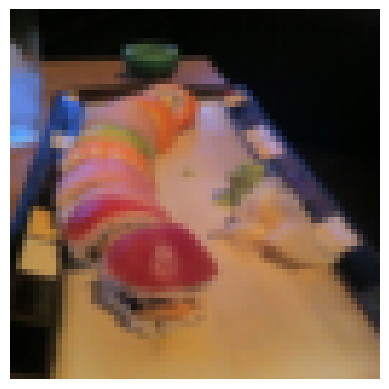

In [283]:
# Plotting the transformed image
plt.imshow(random_image_transformed.permute(1, 2, 0))
plt.axis(False)

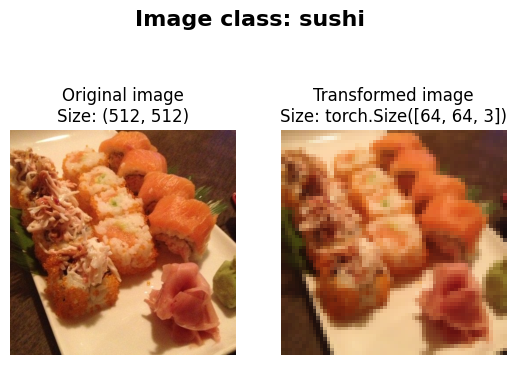

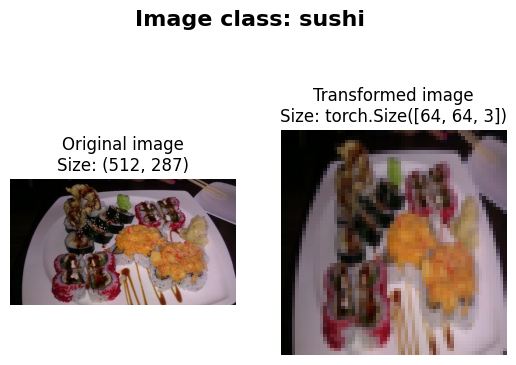

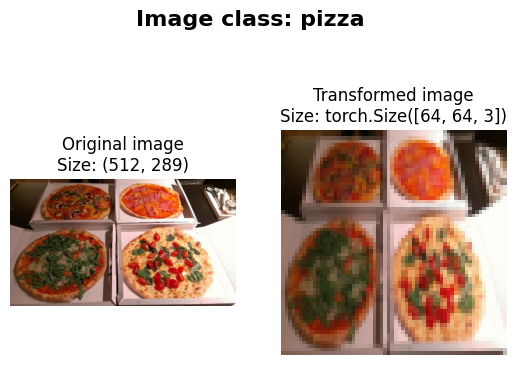

In [284]:
def plot_transformed_images(image_paths, transform, n= 3, seed= None):
    """
    Picks n random images from image_paths and applies the transform to them
    image_paths: (list) list of image paths
    transform: (callable) image transform to be applied
    n: (int) number of images to plot
    seed: (int) random seed for reproducibility
    """
    # Set the seed
    if seed:
        random.seed(seed)

    # Get n random image paths
    random_image_paths = random.sample(image_paths, n)
    
    for image_path in random_image_paths:
        with Image.open(image_path) as img:
            fig, ax = plt.subplots(1, 2)

            # Plot the original image
            ax[0].imshow(img)
            ax[0].set_title(f"Original image\nSize: {img.size}")
            ax[0].axis(False)

            # Transform the image
            transformed_img = transform(img).permute(1, 2, 0) # Change the shape from (C, H, W) to (H, W, C)

            # Plot the transformed image
            ax[1].imshow(transformed_img)
            ax[1].set_title(f"Transformed image\nSize: {transformed_img.shape}")
            ax[1].axis(False)

            fig.suptitle(f"Image class: {image_path.parent.name}", fontsize= 16, fontweight= "bold")


# Plot the transformed images
plot_transformed_images(image_paths, transform= data_transform, seed= 42)

## 4. Option 1: Loading image data using `ImageFolder`

We can load image classification data using `torchvision.datasets.ImageFolder` class.

In [285]:
# Use ImageFolder to create datasets
train_data = datasets.ImageFolder(root= train_dir, # Root directory of dataset (pizza_steak_sushi/train)
                                  transform= data_transform, # Converts images to tensors and apllies other transformations
                                  target_transform= None) # A transform for the labels/targets

test_data = datasets.ImageFolder(root= test_dir,
                                 transform= data_transform,
                                 target_transform= None)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [286]:
# Get the class names as list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [287]:
# Get class names as dictionary
class_names_dict = train_data.class_to_idx
class_names_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [288]:
# Check the length of the training and testing data
len(train_data), len(test_data)

(225, 75)

In [289]:
# Getting a single image and its label
img, label = train_data[0]
img.shape, class_names[label]

(torch.Size([3, 64, 64]), 'pizza')

Image shape: torch.Size([3, 64, 64])
Image shape (permuted): torch.Size([64, 64, 3])


(-0.5, 63.5, 63.5, -0.5)

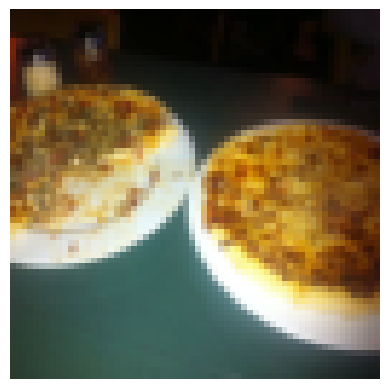

In [290]:
# Rearrange the order of the image tensor
img_permute = img.permute(1, 2, 0)

# Print out different shapes
print(f"Image shape: {img.shape}")
print(f"Image shape (permuted): {img_permute.shape}")

# Plot the image
plt.imshow(img_permute)
plt.axis(False)

### 4.1 Turn the data into DataLoader

The Dataloader turns the datasets into iterable objects that can be used to train the model.

We can also customise the `batch_size` so our model can look at multiple images at once.

In [291]:
import os

# Setting the batch size
BATCH_SIZE = 1

# Turn train and test datasets into DataLoader
train_loader = DataLoader(dataset= train_data,
                          batch_size= BATCH_SIZE,
                          shuffle= True,
                          num_workers=2) # Number of processes to use to prepare the data. `os.cpu_count()` returns the number of logical CPUs in the system

test_loader = DataLoader(dataset= test_data,
                            batch_size= BATCH_SIZE,
                            shuffle= False,
                            num_workers=1)
len(train_loader), len(test_loader)

(225, 75)

In [292]:
# Getting the first iterable batch of images and labels
imgs, labels = next(iter(train_loader))

# Check the shape of the images
print(f"Images shape: {imgs.shape} -> (batch_size, channels, height, width)")
print(f"Labels shape: {labels.shape} -> (batch_size)")

Images shape: torch.Size([1, 3, 64, 64]) -> (batch_size, channels, height, width)
Labels shape: torch.Size([1]) -> (batch_size)


## 5. Option 2: Creating a custom dataset

1. Must be able to load images from file
2. Must be able to load the image label from the Dataset
3. Must be able to return classes as dictionary from Dataset

Pros:
* Can create a custom dataset with any data
* Not limited to PyTorch pre-built dataset functions

Cons:
* More work to implement
* Will leed to more code, often leding to potential bugs

In [293]:
# Insatance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 Creating a helper function to get class names

We will create a helper function to get the class names from the dataset.
1. Get the class names using `os.scan_dir` function to traverse the target directory.
2. Raise an error if the class names are not found.
3. Turn the class names into a dict and a list and return them.

In [294]:
# Setup path for target directory
target_directory = train_dir

# Get the class names from the target directory
class_names_found = sorted([target.name for target in os.scandir(target_directory) if target.is_dir()])
class_names_found

['pizza', 'steak', 'sushi']

In [295]:
def find_classes(dir_path: str) -> Tuple[List[str], Dict[str, int]]:
    """
    Finds the class folders in a dataset
    dir_path: (str) valid path to target directory
    """
    classes = [d.name for d in os.scandir(dir_path) if d.is_dir()]
    classes.sort()
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx

# Get the class names and class to index mapping
class_names, class_to_idx = find_classes(target_directory)
class_names, class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Creating a custom dataset

To create our own custom dataset, we need to:

1. Inherit from `torch.utils.data.Dataset` class.
2. Init our subclass with a target directory and a transform.
3. Create several attributes:
    * `self.image_paths` to store the image paths
    * `self.transform` to store the transform
    * `self.class_names` to store the class names
    * `self.class_name_to_idx` to store the class name to index mapping
4. Create a function to `load_images()`
5. Overwrite the `__len__` function to return the length of the dataset
6. Overwrite the `__getitem__` function to return the image and the label

In [296]:
# Write a custom dataset

# Subclassing torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
    # Initializing our custom dataset
    def __init__(self, target_directory: str, transform= None):
        """
        target_directory: (str) path to the target directory
        transform: (callable) image transform to be applied
        """

        # Creating class attributes
        self.image_paths = list(pathlib.Path(target_directory).glob("*/*.jpg"))
        self.transform = transform
        self.classes, self.class_to_idx = find_classes(target_directory)

    # Create a funtion to load an image
    def load_image(self, index: int) -> Image.Image:
        """
        Opens an image from a file path and returns it
        index: (int) index of the image to be retrieved
        """
        image_path = self.image_paths[index]
        return Image.open(image_path)

    # Get the length of the dataset
    def __len__(self) -> int:
        """
        Returns the total number of samples.
        """
        return len(self.image_paths)

    # Get an image and its label
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        """
        Retrieves an image and its label from the dataset
        index: (int) index of the image to be retrieved
        """
        image = self.load_image(index)
        class_name = self.image_paths[index].parent.name
        class_idx = self.class_to_idx[class_name]
        if self.transform:
            image = self.transform(image)
        return image, class_idx

In [297]:
# Create a transform
train_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])



In [298]:
# Create an instance of ImageFolderCustom
train_data_custom = ImageFolderCustom(train_dir, transform= train_transform)
test_data_custom = ImageFolderCustom(test_dir, transform= test_transform)

In [299]:
# Comparing the custom dataset with the original dataset
len(train_data_custom), len(train_data)

(225, 225)

In [300]:
len(test_data_custom), len(test_data)

(75, 75)

In [301]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [302]:
train_data_custom.class_to_idx, train_data.class_to_idx

({'pizza': 0, 'steak': 1, 'sushi': 2}, {'pizza': 0, 'steak': 1, 'sushi': 2})

In [303]:
# Checking for equality
print(train_data_custom.classes == train_data.classes)
print(train_data_custom.class_to_idx == train_data.class_to_idx)

True
True


### 5.3 Create a function to visualize random images

1. Take in a `Dataset` and a number of other parameters such as class names and how many images to display.
2. To prevent the function from running indefinitely, we will set a maximum number of iterations.
3. Set a random seed for reproductibility.
4. Get a list of random sample indexes from the dataset.
5. Iterate over the indexes and display the images.

In [304]:
# Create a function to take in a dataset
def display_random_images(dataset: Dataset,
                          classes: List[str],
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
    # Adjusting display if n is too high
    if n > 10:
        n = 10
        display_shape = False
        print("Can't display more than 10 images.")

    # Set the seed
    if seed:
        random.seed(seed)

    # Get random samples
    random_images_idx = random.sample(range(len(dataset)), n)

    # Setup plot
    plt.figure(figsize=(16, 8))


    # Loop through the indexes and plot them
    for i, idx in enumerate(random_images_idx):
        img, label = dataset[idx]
        img_permute = img.permute(1, 2, 0) # Always remember to adjust the shape of the image tensor for matplotlib. (C, H, W) -> (H, W, C)

        # Plot the image
        plt.subplot(1, n, i+1)
        plt.imshow(img_permute)
        plt.axis(False)

        if classes:
            title = f"class: {classes[label]}"

            # Add title if display_shape is True
            if display_shape:
                title = title + f"\nshape: {img_permute.shape}"
            
        plt.title(title)
        

        



    

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f9321e09940>
Traceback (most recent call last):
  File "/home/felipe/.local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/home/felipe/.local/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1437, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
                                   ^^^^^^^^^^^^^^^^^^^^
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


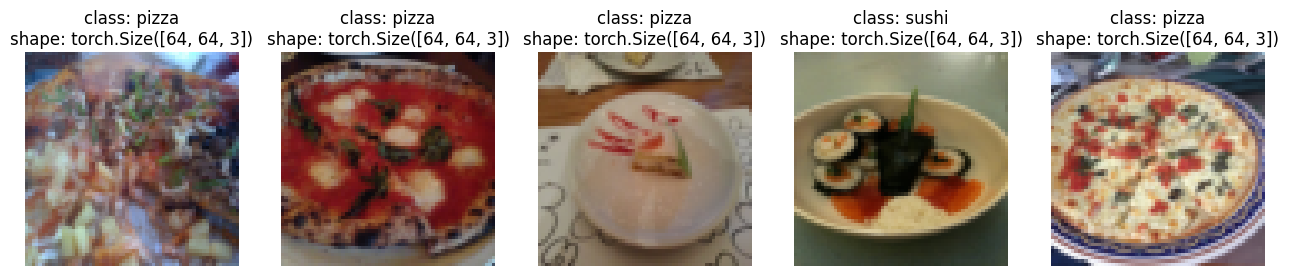

In [305]:
display_random_images(train_data,classes=train_data.classes, n= 5)

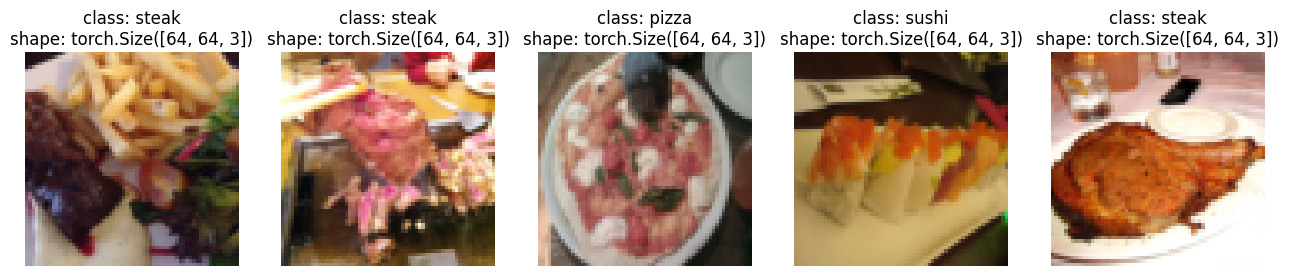

In [306]:
display_random_images(train_data_custom, classes= train_data_custom.classes, n= 5)

### 5.4 Turn custom dataset into DataLoader

In [307]:
BATCH_SIZE = 32
NUM_WORKERS = 2
train_dataloader_custom = DataLoader(dataset= train_data_custom,
                                     batch_size= BATCH_SIZE,
                                     shuffle= True,
                                     num_workers= NUM_WORKERS)

test_dataloader_custom = DataLoader(dataset= test_data_custom,
                                    batch_size= BATCH_SIZE,
                                    shuffle= False,
                                    num_workers= NUM_WORKERS)
train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7f9329dfe930>,
 <torch.utils.data.dataloader.DataLoader at 0x7f92c4a914f0>)

In [308]:
# Get image and label from custom dataloader
imgs, labels = next(iter(train_dataloader_custom))

# Check the shape of the images
print(f"Images shape: {imgs.shape} -> (batch_size, channels, height, width)")
print(f"Labels shape: {labels.shape} -> (batch_size)")

Images shape: torch.Size([32, 3, 64, 64]) -> (batch_size, channels, height, width)
Labels shape: torch.Size([32]) -> (batch_size)


## 6. Other forms of transforms -> Data Augmentation

Data augmentation is a technique used to increase the diversity of your training set by applying random (but realistic) transformations to your training images. 
This helps your model generalize better to the unseen data.

In the case of image data, this may include: 
* rotation
* flipping
* scaling
* cropping.

This practice hopefully results in a model that is more robust and invariant to these changes during training.

In [309]:
# Let's look at one type of data augmentation: trivialaugment
train_transform_trivial = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins= 31), # Copilot is suggesting 15, but following the tutorial (31)
    transforms.ToTensor()
])

test_transform_trivial = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])


In [310]:
# Get all image paths
image_paths = list(image_path.glob("*/*/*.jpg"))
image_paths[:5]

[PosixPath('data/pizza_steak_sushi/train/sushi/390178.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/2175561.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/3426958.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/2813454.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/2323548.jpg')]

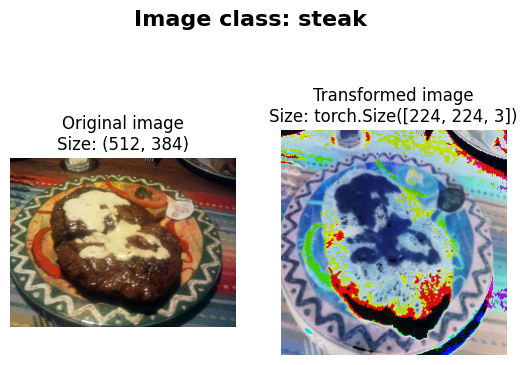

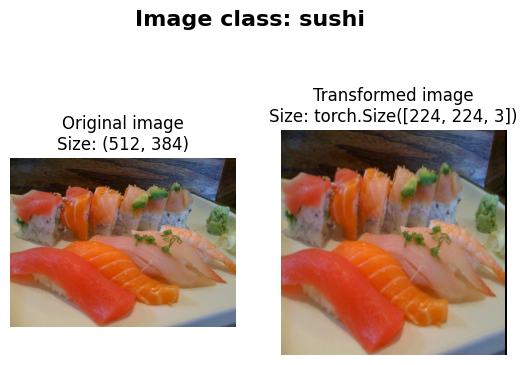

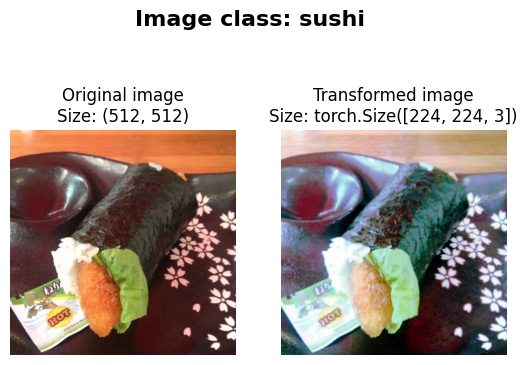

In [311]:
# Plot random images
plot_transformed_images(image_paths,
                         transform= train_transform_trivial,
                         seed= None)

## 7. Model 0: TinyVGG without data augmentation

Replicanting the TinyVGG model from the CNN Explainer website.

### 7.1 Creating transforms and loading data for Model 0

In [312]:
# Create a simple transform
simple_transform = transforms.Compose([
    transforms.Resize((64, 64)), # TinyVGG archictecture uses 64x64 images, Copilot suggested 224x224. Following the tutorial (64x64)
    transforms.ToTensor()
])

In [313]:
# 1. Load and transform data
train_data_simple = datasets.ImageFolder(root= train_dir,
                                         transform= simple_transform)
test_data_simple = datasets.ImageFolder(root= test_dir,
                                        transform= simple_transform)

# 2. Create DataLoader
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_loader_simple = DataLoader(dataset= train_data_simple,
                                 batch_size= BATCH_SIZE,
                                 shuffle= True,
                                 num_workers= NUM_WORKERS)
test_loader_simple = DataLoader(dataset= test_data_simple,
                                batch_size= BATCH_SIZE,
                                shuffle= False,
                                num_workers= NUM_WORKERS)

### 7.2 Creating the TinyVGG model

In [314]:
class TinyVGG(nn.Module):
    """
    TinyVGG architecture from the CNN explainer.
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        # Define the convolutional layers
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0), # Copilot suggested hidden_units*2, following the tutorial (hidden_units)
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(hidden_units* 13 * 13, output_shape), # Check the shape before the flatten layer.
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv_block1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        return x
        # return self.classifier(self.conv_block_2(self.conv_block1(x))) (this is an alternative for optimization)

In [315]:
torch.manual_seed(42)
model_0 = TinyVGG(input_shape= 3, # 3 channels (RGB) 
                  hidden_units= 10, # 8 hidden units
                  output_shape= len(train_data.classes)).to(device) # Number of classes


### 7.3 Trying a forward pass through a single image

In [316]:
# Get a single image batch
image_batch, label_batch = next(iter(train_loader_simple))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [317]:
# Pass the image batch to the model
model_0(image_batch.to(device))

tensor([[ 2.0795e-02, -1.9510e-03,  9.5212e-03],
        [ 1.8440e-02,  2.4669e-03,  6.6609e-03],
        [ 1.7695e-02,  1.0282e-03,  9.4975e-03],
        [ 2.4446e-02, -3.3489e-03,  9.5877e-03],
        [ 1.9939e-02,  6.9130e-04,  1.0778e-02],
        [ 2.1281e-02,  2.0434e-03,  5.0046e-03],
        [ 2.0996e-02,  1.6416e-04,  1.2481e-02],
        [ 2.1566e-02, -1.9607e-03,  9.7175e-03],
        [ 2.4500e-02, -4.7904e-03,  8.5394e-03],
        [ 2.0239e-02, -4.7979e-04,  1.0907e-02],
        [ 2.2219e-02, -4.1816e-04,  9.8173e-03],
        [ 2.2318e-02, -2.1642e-03,  9.4428e-03],
        [ 2.1851e-02, -3.7225e-03,  8.3784e-03],
        [ 2.2881e-02, -1.7559e-03,  1.0299e-02],
        [ 2.1635e-02, -4.3995e-03,  9.4990e-03],
        [ 2.2101e-02, -4.1469e-03,  9.3904e-03],
        [ 2.1226e-02, -4.4215e-03,  1.1476e-02],
        [ 2.1698e-02, -2.7458e-03,  8.4966e-03],
        [ 1.9974e-02, -3.1665e-07,  8.4496e-03],
        [ 1.8308e-02,  1.6378e-03,  8.5491e-03],
        [ 2.0768e-02

### 7.4 Use `torchinfo` to get a summary of the model

In [318]:
from torchinfo import summary

summary(model_0, input_size= image_batch.shape, device= device)

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [32, 3]                   --
├─Sequential: 1-1                        [32, 10, 30, 30]          --
│    └─Conv2d: 2-1                       [32, 10, 62, 62]          280
│    └─ReLU: 2-2                         [32, 10, 62, 62]          --
│    └─Conv2d: 2-3                       [32, 10, 60, 60]          910
│    └─ReLU: 2-4                         [32, 10, 60, 60]          --
│    └─MaxPool2d: 2-5                    [32, 10, 30, 30]          --
├─Sequential: 1-2                        [32, 10, 13, 13]          --
│    └─Conv2d: 2-6                       [32, 10, 28, 28]          910
│    └─ReLU: 2-7                         [32, 10, 28, 28]          --
│    └─Conv2d: 2-8                       [32, 10, 26, 26]          910
│    └─ReLU: 2-9                         [32, 10, 26, 26]          --
│    └─MaxPool2d: 2-10                   [32, 10, 13, 13]          --
├─Sequentia

### 7.5 Create a train and test loops functions

* `train_step` function - takes in a model and dataloader and trains the model on the dataloader
* `test_step` function - takes in a model and dataloader and evaluates the model on the dataloader

In [319]:
# Create train_step()
def train_step(model: nn.Module,
               dataloader: DataLoader,
               loss_fn: nn.Module,
               optimizer: torch.optim.Optimizer,
               device: str) -> Dict[str, float]:
    """
    Trains the model for one epoch
    model: (nn.Module) a neural network model
    dataloader: (DataLoader) a DataLoader object for the training dataset
    loss_fn: (nn.Module) a loss function
    optimizer: (torch.optim.Optimizer) an optimizer
    device: (str) a string specifying the device (cpu or cuda)
    """
    # Set the model to training mode
    model.train()
    train_loss, train_accuracy = 0.0, 0.0

    # Loop over the training set
    for batch, (images, labels) in enumerate(dataloader):
        # Send the data to the device
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)

        # Calculate the loss
        loss = loss_fn(outputs, labels)
        train_loss += loss.item()

        # Zero the gradients
        optimizer.zero_grad()

        # Backpropagate the loss
        loss.backward()

        # Update the model parameters
        optimizer.step()

        # Calculate accuracy
        predictions = torch.argmax(torch.softmax(outputs, dim=1), dim=1)
        train_accuracy += torch.sum(predictions == labels).item()/len(predictions)

    # Adjusting metrics
    train_loss /= len(dataloader)
    train_accuracy /= len(dataloader) 
   
    return {"loss": train_loss, "accuracy": train_accuracy}

# Create test_step()
def test_step(model: nn.Module,
              dataloader: DataLoader,
              loss_fn: nn.Module,
              device: str) -> Dict[str, float]:
    """
    Tests the model on the validation or test set
    model: (nn.Module) a neural network model
    dataloader: (DataLoader) a DataLoader object for the validation or test set
    loss_fn: (nn.Module) a loss function
    device: (str) a string specifying the device (cpu or cuda)
    """
    # Set the model to evaluation mode
    model.eval()
    test_loss, test_accuracy = 0.0, 0.0

    # Turn off gradient computation
    with torch.inference_mode():
        # Loop over the Dataloader batches
        for images, labels in dataloader:
            # Send the data to the device
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)

            # Calculate the loss
            loss = loss_fn(outputs, labels)
            test_loss += loss.item()

            # Calculate accuracy
            predictions = outputs.argmax(dim=1)
            test_accuracy += torch.sum(predictions == labels).item()/len(predictions)

    # Adjusting metrics
    test_loss /= len(dataloader)
    test_accuracy /= len(dataloader)
    
    return {"loss": test_loss, "accuracy": test_accuracy}

### 7.6 Creating a `train()` function that combines the `train_step()` and `test_step()` functions

In [320]:
from tqdm.notebook import tqdm

# 1. Create a train function that takes various models parameters
def train(model: torch.nn.Module,
          train_loader: torch.utils.data.DataLoader,
          test_loader: torch.utils.data.DataLoader,
          loss_fn: torch.nn.Module,
          optimizer: torch.optim.Optimizer,
          device: str,
          num_epochs: int = 5) -> Dict[str, list]:
          
    """
    Trains a neural network model
    model: (torch.nn.Module) a neural network model
    train_loader: (DataLoader) a DataLoader object for the training dataset
    test_loader: (DataLoader) a DataLoader object for the test dataset
    loss_fn: (torch.nn.Module) a loss function
    optimizer: (torch.optim.Optimizer) an optimizer
    num_epochs: (int) the number of epochs to train the model
    device: (str) a string specifying the device (cpu or cuda)
    """
    # Track the metrics
    results = {"train_loss": [], "train_accuracy": [], "test_loss": [], "test_accuracy": []}

    # Train the model
    for epoch in tqdm(range(num_epochs)):
        # Perform a training step
        train_results = train_step(model, train_loader, loss_fn, optimizer, device)

        # Perform a test step
        test_results = test_step(model, test_loader, loss_fn, device)

        # Save the results
        results["train_loss"].append(train_results["loss"])
        results["train_accuracy"].append(train_results["accuracy"])
        results["test_loss"].append(test_results["loss"])
        results["test_accuracy"].append(test_results["accuracy"])

        # Display the results
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_results['loss']:.4f}, Train Accuracy: {train_results['accuracy']:.4f}, Test Loss: {test_results['loss']:.4f}, Test Accuracy: {test_results['accuracy']:.4f}")

    return results

### 7.7 Train and evaluate Model 0

In [321]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Set the number of epochs
NUM_EPOCHS = 100

# Reacreate an instance of the TinyVGG model
model_0 = TinyVGG(input_shape= 3, # 3 channels (RGB) 
                  hidden_units= 10, 
                  output_shape= len(train_data.classes)).to(device) # Number of classes

# Setup the loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr= 0.001) # Trying instead of SGD

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train the model
model_0_results = train(model_0, train_loader_simple, test_loader_simple, loss_fn, optimizer, device, num_epochs= NUM_EPOCHS)

# End the timer
end_time = timer()

# Calculate the total time
total_time = end_time - start_time
print(f"Total training time: {total_time/60:.2f} minutes")
print("history_0: ", model_0_results)


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100, Train Loss: 1.1063, Train Accuracy: 0.3047, Test Loss: 1.0983, Test Accuracy: 0.3011
Epoch 2/100, Train Loss: 1.0998, Train Accuracy: 0.3281, Test Loss: 1.0697, Test Accuracy: 0.5417
Epoch 3/100, Train Loss: 1.0869, Train Accuracy: 0.4883, Test Loss: 1.0808, Test Accuracy: 0.4924
Epoch 4/100, Train Loss: 1.0844, Train Accuracy: 0.4023, Test Loss: 1.0607, Test Accuracy: 0.5833
Epoch 5/100, Train Loss: 1.0663, Train Accuracy: 0.4141, Test Loss: 1.0657, Test Accuracy: 0.5644
Epoch 6/100, Train Loss: 1.0310, Train Accuracy: 0.4375, Test Loss: 1.0148, Test Accuracy: 0.5426
Epoch 7/100, Train Loss: 0.9870, Train Accuracy: 0.4180, Test Loss: 0.9381, Test Accuracy: 0.6146
Epoch 8/100, Train Loss: 0.9552, Train Accuracy: 0.5430, Test Loss: 1.0241, Test Accuracy: 0.4432
Epoch 9/100, Train Loss: 0.9261, Train Accuracy: 0.5859, Test Loss: 1.1073, Test Accuracy: 0.3324
Epoch 10/100, Train Loss: 0.9857, Train Accuracy: 0.4648, Test Loss: 1.0141, Test Accuracy: 0.4233
Epoch 11/100, Train

### 7.8 Plot the loss curves of Model 0

A loss curve is a plot of the model's loss over time. It is a good way to see how the model is learning.

In [322]:
# Get the model_0_results keys
model_0_results.keys()

dict_keys(['train_loss', 'train_accuracy', 'test_loss', 'test_accuracy'])

In [323]:
def plot_loss_curves(results: Dict[str, List[float]]) -> None:
    """
    Plots the loss and accuracy curves
    results: (dict) a dictionary containing "train_loss", "train_accuracy", "test_loss", and "test_accuracy" keys
    """
    # Get the loss values of the results dictionary(training and testing)
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    # Get the accuracy values of the results dictionary(training and testing)
    accuracy = results["train_accuracy"]
    test_accuracy = results["test_accuracy"]

    # Get epochs
    epochs = range(len(loss))

    # Set the figure
    plt.figure(figsize=(12, 6))

    # Plot the training loss
    plt.subplot(1, 2, 1)
    plt.plot(loss, label="train_loss", marker="o")
    plt.plot(test_loss, label="test_loss", marker="o")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # Plot the training accuracy
    plt.subplot(1, 2, 2)
    plt.plot(accuracy, label="train_accuracy", marker="o")
    plt.plot(test_accuracy, label="test_accuracy", marker="o")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    # Show the plot
    plt.show()

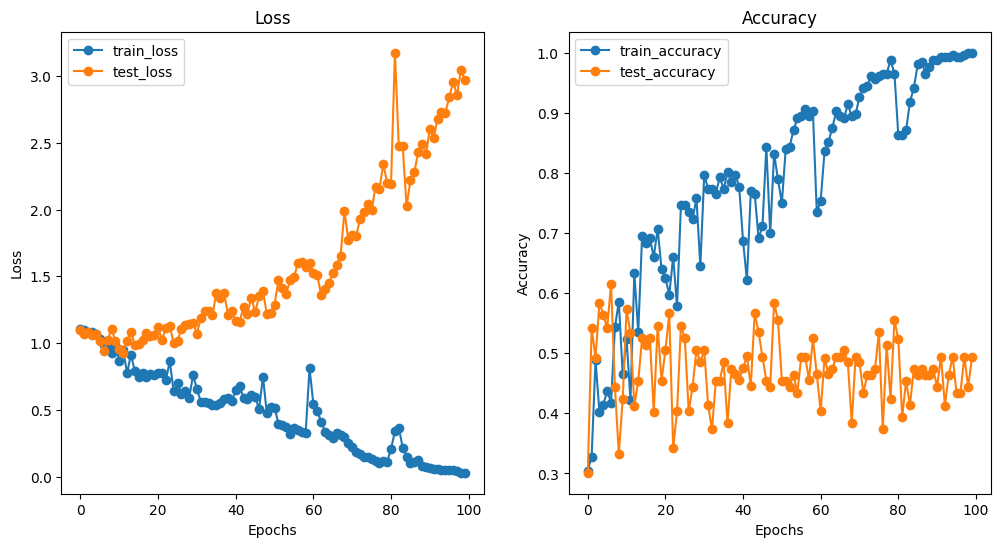

In [324]:
plot_loss_curves(model_0_results)

## 8. What should an ideal loss curve look like?

A loss curve is one of the most helpful ways to understand how a model is learning.

There are three main types of loss curves:
1. **Overfitting**: The model is learning too well on the training data and not generalizing well to the validation data.
2. **Underfitting**: The model is not learning well on the training data and is not generalizing well to the validation data.
3. **Good fit**: The model is learning well on the training data and generalizing well to the validation data.

Some ways to deal with overfitting:
* Get more data
* Use data augmentation
* Use transfer learning
* Build simpler models
* Use learning rate decay
* Use early stopping

Some ways to deal with underfitting:
* Add more layers
* Tweaking the learning rate
* Train for longer
* Use transfer learning
* Use less regularization


## 9. Model 1: TinyVGG with data augmentation

Experimenting the same architecture with data augmentation to see if it improves the model's performance.

### 9.1 Creating transforms with data augmentation

In [325]:
# Create training transform with TriviailAugment
train_transform_trivial = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins= 31), # Copilot is suggesting 15, but following the tutorial (31)
    transforms.ToTensor()
])

# Create test transform (it is not required to use TrivialAugment on the test set, because it is only used for evaluation, not for learning.)
test_transform_trivial = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])



### 9.2 Create train and test `Dataset`s and `DataLoader`s with data augmentation

In [326]:
# Turn image folder into Datasets
train_data_augmented = datasets.ImageFolder(root= train_dir,
                                            transform= train_transform_trivial)
test_data_simple = datasets.ImageFolder(root= test_dir,
                                        transform= test_transform_trivial)

In [327]:
# Turn datasets into DataLoader
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
torch.manual_seed(42)

train_loader_augmented = DataLoader(dataset= train_data_augmented,
                                    batch_size= BATCH_SIZE,
                                    shuffle= True,
                                    num_workers= NUM_WORKERS)

test_loader_simple = DataLoader(dataset= test_data_simple,
                                batch_size= BATCH_SIZE,
                                shuffle= False,
                                num_workers= NUM_WORKERS)

### 9.3 Construct and train model 1

Same model as Model 0 but with data augmentation.

In [328]:
# Create model_1 and send to device
model_1 = TinyVGG(input_shape= 3, # 3 channels (RGB) 
                  hidden_units= 10, 
                  output_shape= len(train_data_augmented.classes)).to(device) # Number of classes
model_1

TinyVGG(
  (conv_block1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [329]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Set the number of epochs
NUM_EPOCHS = 100

# Setup the loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_1.parameters(), lr= 0.001)

# Start the timer
start_time = timer()

# Train the model
model_1_results = train(model_1, train_loader_augmented, test_loader_simple, loss_fn, optimizer, device, num_epochs= NUM_EPOCHS)

# End the timer
end_time = timer()

# Calculate the total time
total_time = end_time - start_time

print(f"Total training time: {total_time:.3f} seconds")

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100, Train Loss: 1.1045, Train Accuracy: 0.2500, Test Loss: 1.1016, Test Accuracy: 0.2604
Epoch 2/100, Train Loss: 1.0760, Train Accuracy: 0.4258, Test Loss: 1.1316, Test Accuracy: 0.2604
Epoch 3/100, Train Loss: 1.0730, Train Accuracy: 0.4258, Test Loss: 1.1704, Test Accuracy: 0.2604
Epoch 4/100, Train Loss: 1.1222, Train Accuracy: 0.3047, Test Loss: 1.1541, Test Accuracy: 0.2604
Epoch 5/100, Train Loss: 1.0735, Train Accuracy: 0.4570, Test Loss: 1.1494, Test Accuracy: 0.3021
Epoch 6/100, Train Loss: 1.0973, Train Accuracy: 0.3984, Test Loss: 1.1373, Test Accuracy: 0.3125
Epoch 7/100, Train Loss: 1.0298, Train Accuracy: 0.5586, Test Loss: 1.1181, Test Accuracy: 0.3125
Epoch 8/100, Train Loss: 1.0560, Train Accuracy: 0.5000, Test Loss: 1.0897, Test Accuracy: 0.3021
Epoch 9/100, Train Loss: 1.0325, Train Accuracy: 0.4883, Test Loss: 1.0737, Test Accuracy: 0.3835
Epoch 10/100, Train Loss: 0.9715, Train Accuracy: 0.5664, Test Loss: 0.9700, Test Accuracy: 0.5038
Epoch 11/100, Train

In [330]:
model_1_results

{'train_loss': [1.10450878739357,
  1.076048344373703,
  1.0730266571044922,
  1.1221755594015121,
  1.0734719038009644,
  1.0973406285047531,
  1.0297588855028152,
  1.0560066029429436,
  1.0325179696083069,
  0.9714625477790833,
  0.921996034681797,
  0.9288002923130989,
  0.9126525595784187,
  0.9082103110849857,
  1.064714439213276,
  0.9300336018204689,
  0.9592136964201927,
  1.0067403018474579,
  0.8999271020293236,
  0.939642995595932,
  0.9213997349143028,
  1.0479676127433777,
  0.9234568700194359,
  0.9538687318563461,
  0.8985086381435394,
  1.0047464445233345,
  0.9431318193674088,
  0.9060914069414139,
  0.8827405050396919,
  0.9343835785984993,
  0.9410009980201721,
  0.8985647261142731,
  0.9063593670725822,
  0.9355643838644028,
  1.0389255732297897,
  0.937038317322731,
  0.9125421866774559,
  0.8734124898910522,
  0.9103871136903763,
  0.846859946846962,
  0.9605472981929779,
  0.9236156120896339,
  0.8643956929445267,
  0.9018735587596893,
  0.9926839172840118,
  0.

### 9.4 Plot the loss curves of Model 1

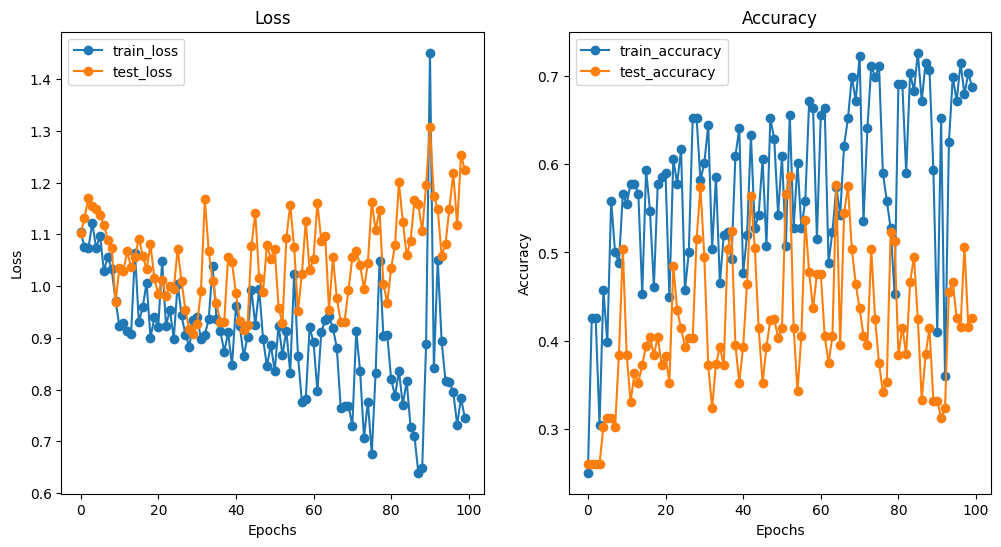

In [331]:
plot_loss_curves(model_1_results)

## 10. Compare model results

Comparing the results of Model 0 and Model 1 to see if data augmentation improved the model's performance.

Some ways to compare models:
1. Hard coding the results
2. PyTorch `torchmetrics` library
3. Weight and bias
4. MLFlow

In [332]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)
model_0_df

,train_loss,train_accuracy,test_loss,test_accuracy
0,1.106319,0.304688,1.098321,0.301136
1,1.099801,0.328125,1.069699,0.541667
2,1.086877,0.488281,1.080764,0.492424
3,1.084427,0.402344,1.060741,0.583333
4,1.066299,0.414062,1.065660,0.564394
...,...,...,...,...
95,0.050299,0.992188,2.839336,0.433712
96,0.048278,0.992188,2.953867,0.433712
97,0.041659,0.996094,2.855746,0.494318
98,0.031962,1.000000,3.047269,0.444129


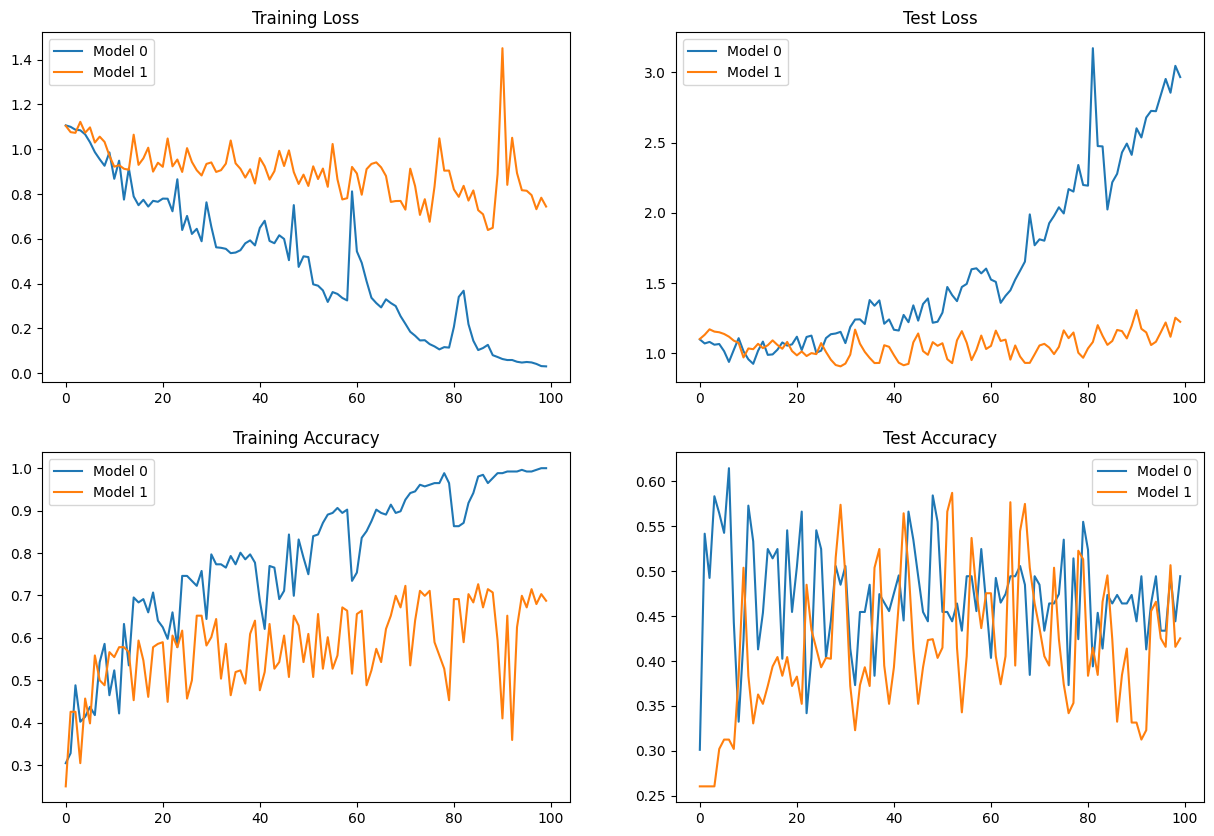

In [338]:
# Setup plotting
plt.figure(figsize=(15, 10))

# Plot the training loss
plt.subplot(2, 2, 1)
plt.plot(model_0_df["train_loss"], label="Model 0")
plt.plot(model_1_df["train_loss"], label="Model 1")
plt.title("Training Loss")
plt.legend()

# Plot the test loss
plt.subplot(2, 2, 2)
plt.plot(model_0_df["test_loss"], label="Model 0")
plt.plot(model_1_df["test_loss"], label="Model 1")
plt.title("Test Loss")
plt.legend()

# Plot the training accuracy
plt.subplot(2, 2, 3)
plt.plot(model_0_df["train_accuracy"], label="Model 0")
plt.plot(model_1_df["train_accuracy"], label="Model 1")
plt.title("Training Accuracy")
plt.legend()

# Plot the test accuracy
plt.subplot(2, 2, 4)
plt.plot(model_0_df["test_accuracy"], label="Model 0")
plt.plot(model_1_df["test_accuracy"], label="Model 1")
plt.title("Test Accuracy")
plt.legend()

# In the future, trying to add more hidden units and more epochs to see if the model can improve its performance.


## 11. Making a prediction with our model

How do we make a prediction with our model?

In [334]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = DATA_PATH / "pizza-test.jpg"

# Download the custom image
if not custom_image_path.is_file():
    url = "https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg"
    with open(custom_image_path, "wb") as f:
        response = requests.get(url)
        print(f"Downloading {url}...")
        f.write(response.content)
else:
    print("Custom image already downloaded.")

Custom image already downloaded.


### 11.1 Loading in a custom image with PyTorch

We have to make sure that the image is in the same format as the images in the dataset.

* In tensor form with data type `torch.float32`
* Of shape `(64, 64, 3)`
* On the right device (CPU or GPU)

In [335]:
# Read in custom image
custom_image = torchvision.io.read_image(str(custom_image_path))
print(f"Custom image tensor: {custom_image}")
print(f"Custom image shape: {custom_image.shape}")
print(f"Custom image dtype: {custom_image.dtype}")

Custom image tensor: tensor([[[154, 173, 181,  ...,  21,  18,  14],
         [146, 165, 181,  ...,  21,  18,  15],
         [124, 146, 172,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 190, 193,  ...,  22,  19,  15],
         [163, 182, 193,  ...,  22,  19,  16],
         [141, 163, 184,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 107, 104, 103],
         [ 47,  38,  24,  ..., 108, 104, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[119, 138, 147,  ...,  17,  14,  10],
         [111, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  52,  52,  48],
         [ 27,  18,   4,  ...,  50,  49,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)
Custom image shape: torch.Size([3, 4032, 3024])
Custom image dtype

(-0.5, 3023.5, 4031.5, -0.5)

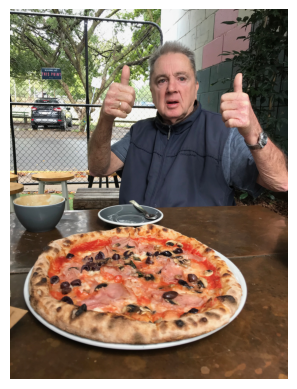

In [336]:
plt.imshow(custom_image.permute(1, 2, 0))
plt.axis(False)

### 11.2 Making a prediction with our model

In [337]:
# Try to make a prediction on an image in uint8 format
model_1.eval()
with torch.inference_mode():
    custom_image = custom_image.to(device)
    custom_image_preds = model_1(custom_image)

    # This will generate an error because the model is expecting a float32 tensor
    

RuntimeError: Input type (unsigned char) and bias type (float) should be the same

In [ ]:
# Load in the custom image and convert to torch.float32
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32) / 255.0
custom_image.shape, custom_image.dtype

(torch.Size([3, 4032, 3024]), torch.float32)

In [ ]:
# Make a prediction on the custom image
model_1.eval()
with torch.inference_mode():
    custom_image = custom_image.to(device)
    custom_image_preds = model_1(custom_image)

# This will generate a size mismatch error, because the model is expecting a 64x64 image, but the custom image is 384x512.

RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x756765 and 1690x3)

In [ ]:
# Create transform pipeline to resize image
custom_image_transform = transforms.Compose([
    transforms.Resize((64, 64))
])

# Transform the custom image
custom_image_tensor = custom_image_transform(custom_image)
custom_image_tensor.shape

torch.Size([3, 64, 64])

In [ ]:
# Making a prediction on the custom image
model_1.eval()
with torch.inference_mode():
    custom_image_tensor = custom_image_tensor.to(device)
    custom_image_preds = model_1(custom_image_tensor)
    # This will generate an error because the model is expecting a batch of images, not a single image.

RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x169 and 1690x3)

In [ ]:
# Add a batch dimension to the custom image tensor
custom_image_tensor = custom_image_tensor.unsqueeze(0)
custom_image_tensor.shape

torch.Size([1, 3, 64, 64])

In [ ]:
# Making a prediction on the custom image
model_1.eval()
with torch.inference_mode():
    custom_image_tensor = custom_image_tensor.to(device)
    custom_image_preds = model_1(custom_image_tensor)
custom_image_preds

tensor([[ 0.0658,  0.0334, -0.2172]])

In [ ]:
# Convert logits to probabilities
custom_image_preds = torch.softmax(custom_image_preds, dim=1)
custom_image_preds

tensor([[0.3674, 0.3557, 0.2769]])

In [ ]:
# Convert probabilities to class labels
custom_image_preds_argmax = custom_image_preds.argmax().cpu()
custom_image_preds_argmax

tensor(0)

In [ ]:
# Getting the class name from the class index
class_names[custom_image_preds_argmax]

'pizza'

### 11.3 Putting custom image prediction together: building a function

In [343]:
def pred_and_plot_image(model: nn.Module, 
                        image_path: str,
                        device: str,
                        class_names: List[str] = None,
                        transform= None) -> None:
    # Load the imagem
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32) / 255.0

    # Transform the image
    if transform:
        target_image = transform(target_image)

    # Assuring model is in device
    model.to(device)

    # Turn on eval/inference mode and make a prediction
    model.eval()
    with torch.inference_mode():
        # Add a batch dimension
        target_image = target_image.unsqueeze(0).to(device)

        # Forward pass
        target_image_preds = model(target_image)

        # Convert logits to probabilities
        target_image_preds = torch.softmax(target_image_preds, dim=1)

        # Convert probabilities to class labels
        target_image_preds_argmax = target_image_preds.argmax().cpu()

        # Plot the image
        plt.imshow(target_image.squeeze().permute(1, 2, 0))
        if class_names:
            plt.title(f"Prediction: {class_names[target_image_preds_argmax.cpu()]} | Probability: {target_image_preds.max().cpu():.3f}")
        else: 
            plt.title(f"Prediction: {target_image_preds_argmax.cpu()} | Probability: {target_image_preds.max().cpu():.3f}")

        plt.axis(False)


    


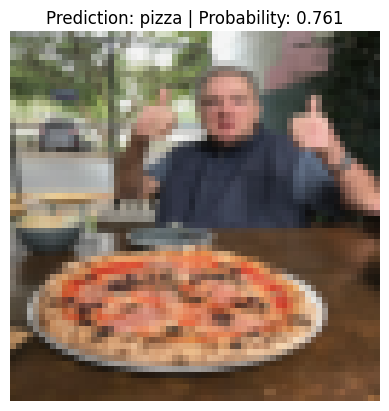

In [344]:
# Pred on our custom image
pred_and_plot_image(model= model_1,
                    image_path= custom_image_path,
                    device= device,
                    class_names= class_names,
                    transform= custom_image_transform)